#### Homography is a projective transformation. For a 2d projective transform, after homogenization of coordinates, we get a matrix with 8 unknowns. Hence we need 4 points in each image at minimum to compute the homography between them.
#### The four points will result in 8 equations, using which, we can solve the homography H $$Hx_i = x_i', i \in [1, 4]$$
#### H = $\begin{bmatrix} h_1 & h_2 & h_3 \\ h_4 & h_5 & h_6 \\ h_7 & h_8 & h_9 \end{bmatrix}$, setting one element $h_9 = 1$ leaves us with 8 degrees of freedom.
#### Now, to solve this system of equations
#### A = $\begin{bmatrix} x_1 & y_1 & 1 & 0 & 0 & 0 & -x_1x_1' & -y_1x_1' \\ 0 & 0 & 0 & x_1 & y_1 & 1 & -x_1y_1' & -y_1y_1' \\ \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\ x_n & y_n & 1 & 0 & 0 & 0 & -x_nx_n' & -y_nx_n' \\ 0 & 0 & 0 & x_n & y_n & 1 & -x_ny_n' & -y_ny_n' \end{bmatrix}$ h = $\begin{bmatrix} h_1 \\ h_2 \\ h_3 \\ \vdots \\ h_8 \end{bmatrix}$ c = $\begin{bmatrix} x_1' \\ y_1' \\ \vdots \\ x_N' \\ y_N' \end{bmatrix}$

#### In our case, N = 4. Since A is then a square matric, we can solve for $$h = A^{-1}c$$

In [49]:
# Imports
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib as mtplt
import numpy as np
import cv2

## Load and Display Images

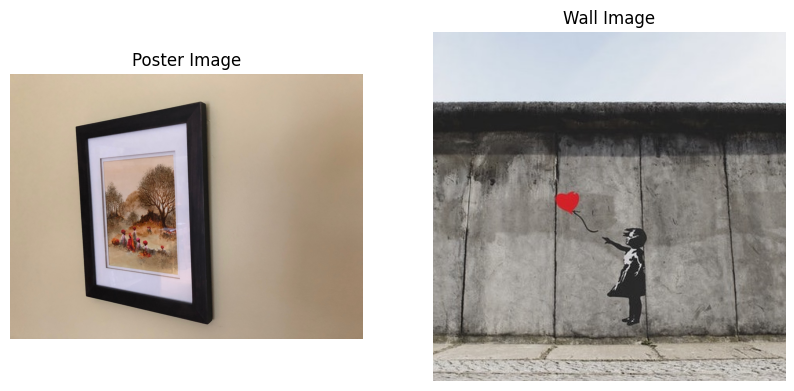

In [50]:
# Load images
poster_image = mpimg.imread('HW2_image1.jpg')
poster_image = np.rot90(poster_image, 2)
wall_image = mpimg.imread('HW2_image2.jpg')

# Create subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Display the first image (poster_image)
axs[0].imshow(poster_image, origin='upper')
axs[0].axis('off')  # Hide axes for the first image
axs[0].set_title('Poster Image')

# Display the second image (wall_image)
axs[1].imshow(wall_image, origin='upper')
axs[1].axis('off')  # Hide axes for the second image
axs[1].set_title('Wall Image')

# Show the plot with both images
plt.show()


## Choose Points in both Images for computing Homographies

In [51]:
# To allow an interactive display of images for clicking and manually getting the points.
mtplt.use('TkAgg')

# Number of points to choose
NUM_POINTS = 4

# Load images
poster_image = mpimg.imread('HW2_image1.jpg')
poster_image = np.rot90(poster_image, 2)
wall_image = mpimg.imread('HW2_image2.jpg')

# Click points on image1
plt.imshow(poster_image)
poster_points = plt.ginput(NUM_POINTS)
print(poster_points)

# Click points on image2
plt.imshow(wall_image)
wall_points = plt.ginput(NUM_POINTS)
print(wall_points)

[(928.6391018619935, 460.46823658269454), (535.6489594742608, 502.52738225629787), (567.1933187294634, 1082.1549835706462), (949.6686746987954, 1142.6150054764512)]
[(446.6509414280498, 0.554538500321712), (0.41056868165298965, 0.942236478381119), (1.1859646377718036, 444.8564213564214), (448.589431318347, 443.3056294441837)]


## Compute Homography

In [52]:
NUM_POINTS = 4

def compute_homography(source_points, destination_points):
    # Get number of points.
    num_points = len(source_points)

    # Construct the system of linear equations for computing homography of the form Ah = C
    # Assuming that the bottom right element of the homography is 1, giving 8 DOF.
    A = np.zeros((2*num_points, 8))

    C = np.zeros(8)
    C = C.reshape(-1, 1)

    # Populate A.
    for i in range(num_points):
        # Fill the 2*i th row
        x1 = source_points[i][0]
        y1= source_points[i][1]

        x2 = destination_points[i][0]
        y2 = destination_points[i][1]

        A[2*i, :] = [
            x1, y1, 1, 0, 0, 0, -x1*x2, -x2*y1
        ]

        C[2*i] = x2

        A[2*i+1, :] = [
            0, 0, 0, x1, y1, 1, -y2*x1, -y2*y1
        ]

        C[2*i + 1] = y2

    if num_points == 4:
        # Naive approach
        h = np.linalg.inv(A)@C


    H = np.append(h, 1).reshape(3, 3)
    return H



In [53]:
H = compute_homography(wall_points, poster_points)
print("Computed Homography = ", H)


# Convert points to numpy arrays
poster_points = np.array(poster_points, dtype='float32')
wall_points = np.array(wall_points, dtype='float32')

# Convert to the shape required by cv2.findHomography
poster_points_for_cv2 = poster_points.reshape(-1, 1, 2)
wall_points_for_cv2 = wall_points.reshape(-1, 1, 2)
H1 = cv2.findHomography(wall_points, poster_points)
print("Computed Homography by CV2 function = ", H1)

Computed Homography =  [[ 5.56756693e-01  1.19452659e-01  5.35275354e+02]
 [-2.53667816e-01  1.40027727e+00  5.01281680e+02]
 [-3.48781534e-04  8.76516436e-05  1.00000000e+00]]
Computed Homography by CV2 function =  (array([[ 5.56756903e-01,  1.19452255e-01,  5.35275382e+02],
       [-2.53667674e-01,  1.40027685e+00,  5.01281672e+02],
       [-3.48781240e-04,  8.76511227e-05,  1.00000000e+00]]), array([[1],
       [1],
       [1],
       [1]], dtype=uint8))


## Map source image into destination image

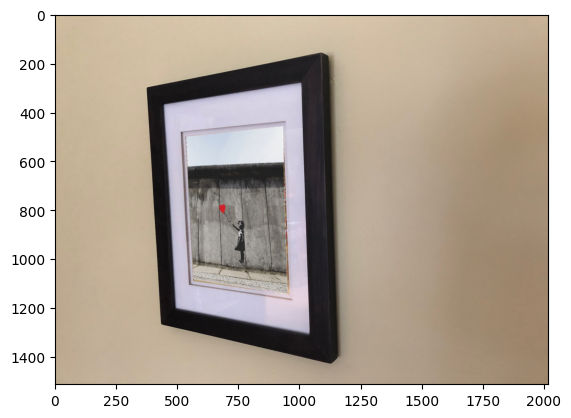

In [55]:
%matplotlib inline

# Create an image matrix of size equal to destination and warp the source image into it,
# using the computed homography.
warped_image = cv2.warpPerspective(wall_image, H,(poster_image.shape[1],poster_image.shape[0]))

# Mask the poster image inside the polygon given by the selected points.
masked_image = cv2.fillPoly(poster_image.copy(), [poster_points_for_cv2.astype(int)], 0)

# # Bitwise or to combine the warped image and the masked image.
overlayed_image = cv2.bitwise_or(warped_image, masked_image)
plt.imshow(overlayed_image)
plt.show()